In [ ]:
!pip install astronn equinox einops

In [1]:
from astroNN.datasets import load_galaxy10
from astroNN.datasets.galaxy10 import galaxy10cls_lookup, galaxy10_confusion
import numpy as np
import matplotlib.pyplot as plt
import jax
import torch

2024-05-24 00:55:31.649698: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-24 00:55:31.649868: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-24 00:55:31.652136: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-24 00:55:31.681004: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-24 00:55:32.174417: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warnin

In [2]:
print(f"CUDA is available: {torch.cuda.is_available()}")

if not torch.cuda.is_available():
    print("If you want, you might want to switch to a GPU-accelerated session!")
    device = torch.device('cpu')
else:
    device = torch.device('cuda')

CUDA is available: False
If you want, you might want to switch to a GPU-accelerated session!


In [3]:
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

set_seed(0)

# Galaxy 10 DECals

In [4]:
# To load images and labels (will download automatically at the first time)
# First time downloading location will be ~/.astroNN/datasets/
images, labels = load_galaxy10()

/home/lukas/.astroNN/datasets/Galaxy10_DECals.h5 was found!


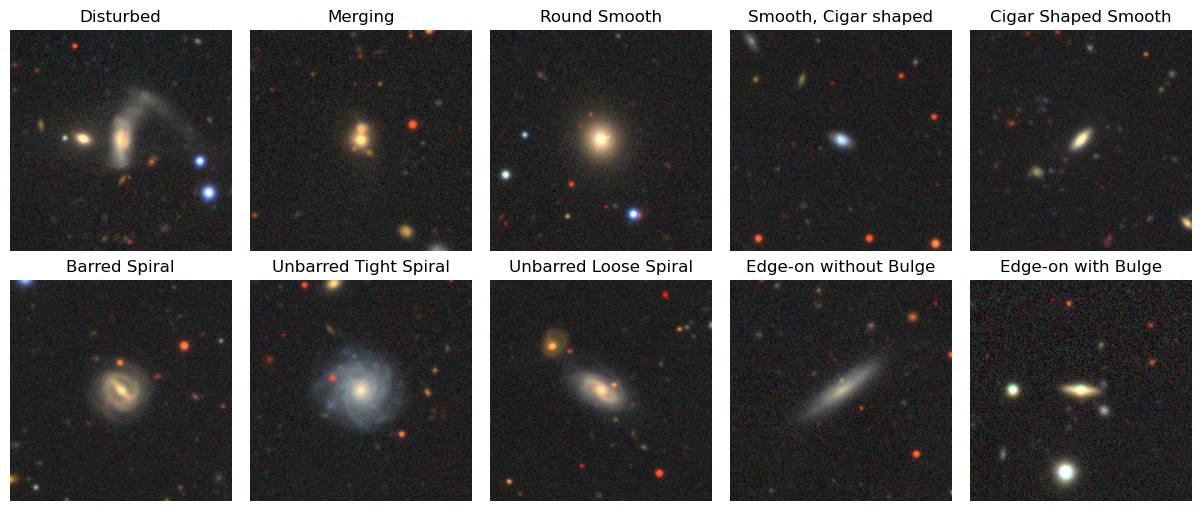

In [5]:
fig, axs = plt.subplots(2, 5, figsize=(12,5), layout='constrained')

for ax, label in zip(np.ravel(axs), range(10)):
    idx = np.where(labels == label)[0][0]
    image = images[idx]

    ax.imshow(image)
    ax.axis('off')
    ax.set_title(galaxy10cls_lookup(label))

#### Remove classes that are not Spiral-like

In [6]:
remove_labels = [0,1,2,3,4,8,9]

for label in remove_labels:
    idx = labels != label
    labels = labels[idx]
    images = images[idx]

#### Shift labels to 0-4

In [7]:
labels = labels - 5

galaxy10cls_lookup_shift = lambda x: galaxy10cls_lookup(x+5)

#### Rescale images

In [8]:
images.shape

(6500, 256, 256, 3)

In [9]:
images = jax.vmap(lambda x: x / 255)(images)

# crop the image a bit to get 64x64 shape
def crop_center(images, cropx, cropy):
    _, y, x, _ = images.shape
    startx = x // 2 -(cropx // 2)
    starty = y // 2 -(cropy // 2)
    return images[:, starty:starty+cropy, startx:startx+cropx, :]

images = crop_center(images=images, cropx=64, cropy=64)

In [10]:
images.shape

(6500, 64, 64, 3)

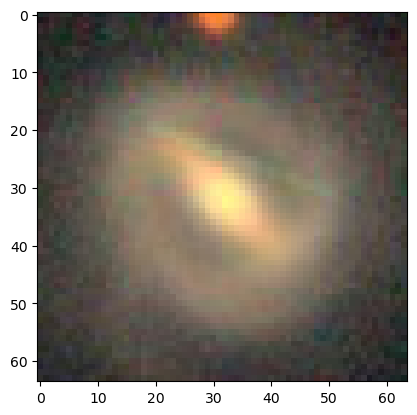

In [11]:
plt.imshow(images[0])

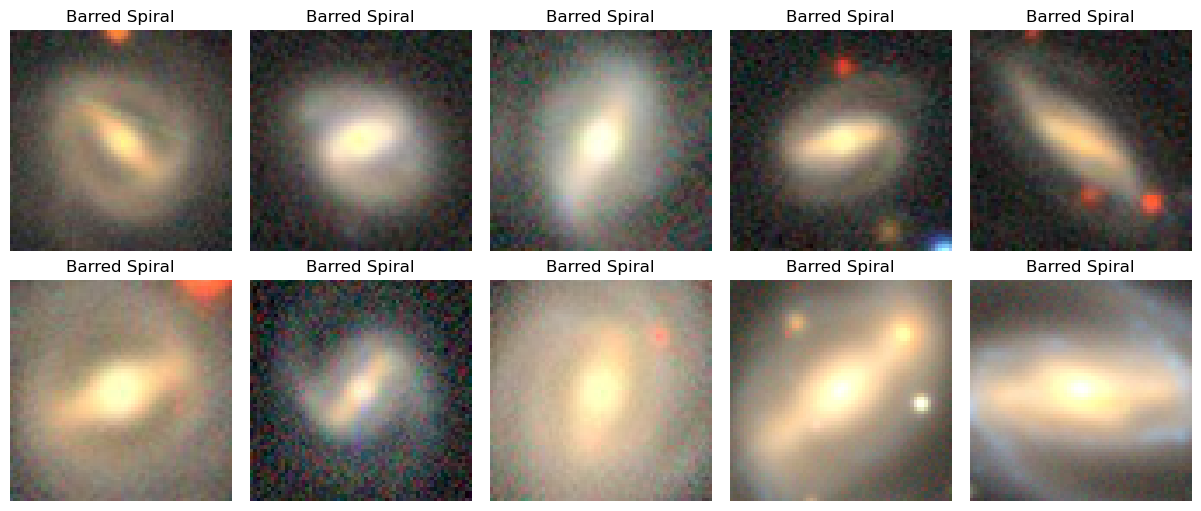

In [12]:
fig, axs = plt.subplots(2, 5, figsize=(12,5), layout='constrained')

for ax, idx in zip(np.ravel(axs), range(10)):
    image = images[idx]
    label = labels[idx]

    ax.imshow(image)
    ax.axis('off')
    ax.set_title(galaxy10cls_lookup_shift(label))

In [13]:
confusion_matrix = np.zeros((5,5))


# create the confusion matrix
for counter, i in enumerate(labels):
    confusion_matrix[i, labels[counter]] += 1

# Plot the confusion matrix
# galaxy10_confusion(confusion_matrix)

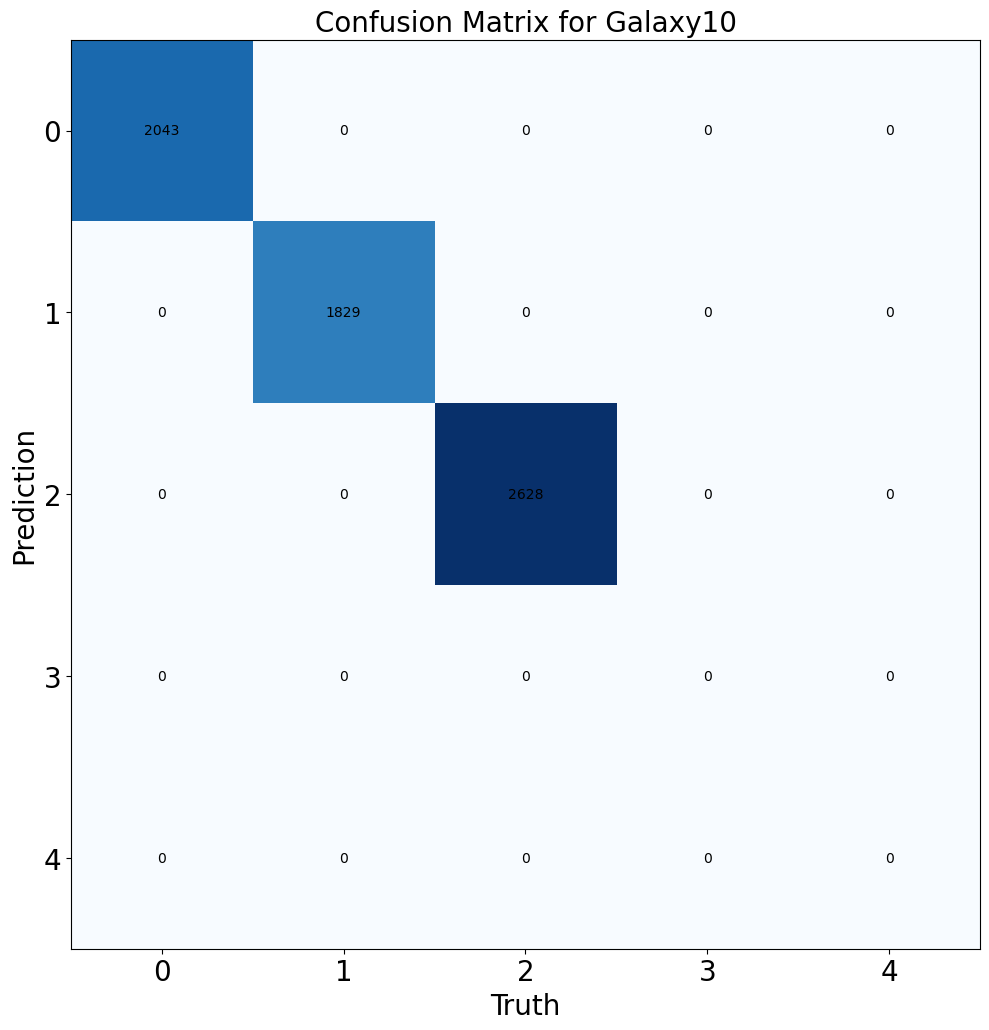

In [14]:
galaxy10_confusion(confusion_matrix)

# Task: Find the galaxy that looks most similar to Milky Way

<img src="https://d2pn8kiwq2w21t.cloudfront.net/original_images/jpegPIA10748.jpg" width=300>

In [15]:
import torch
import torchvision as tv

def get_convert_mikly_way():
    !wget https://d2pn8kiwq2w21t.cloudfront.net/original_images/jpegPIA10748.jpg

    milky_way = tv.io.read_image("./jpegPIA10748.jpg")
    milky_way = tv.transforms.Resize(size=64)(milky_way)
    milky_way = milky_way.permute(1,2,0).to(torch.float32)
    return milky_way / 255

def jax_to_torch(jax_tensor):
    return torch.from_numpy(np.asarray(jax_tensor))

In [16]:
mw = get_convert_mikly_way()
images = jax_to_torch(np.copy(images))

--2024-05-24 00:56:13--  https://d2pn8kiwq2w21t.cloudfront.net/original_images/jpegPIA10748.jpg
Loaded CA certificate '/etc/ssl/certs/ca-certificates.crt'
Resolving d2pn8kiwq2w21t.cloudfront.net (d2pn8kiwq2w21t.cloudfront.net)... 18.65.40.22, 18.65.40.193, 18.65.40.31, ...
Connecting to d2pn8kiwq2w21t.cloudfront.net (d2pn8kiwq2w21t.cloudfront.net)|18.65.40.22|:443... connected.


/home/lukas/.local/mambaforge/envs/advanced_school/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.


HTTP request sent, awaiting response... 200 OK
Length: 2049707 (2,0M) [image/jpeg]
Saving to: ‘jpegPIA10748.jpg.4’

jpegPIA10748.jpg.4  100%[===================>]   1,95M  5,93MB/s    in 0,3s    

2024-05-24 00:56:14 (5,93 MB/s) - ‘jpegPIA10748.jpg.4’ saved [2049707/2049707]



In [17]:
mw_torch = mw.permute(2,0,1)
images_torch = images.permute(0,3,1,2)

## Get wasserstein distance

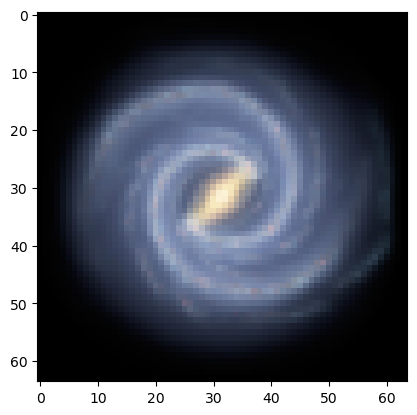

In [18]:
plt.imshow(mw)

In [19]:
from scipy.stats import wasserstein_distance_nd
from tqdm.notebook import tqdm

In [20]:
w_dist = []
for img in tqdm(images_torch):
    d_red = wasserstein_distance_nd(img[0], mw_torch[0])
    d_green = wasserstein_distance_nd(img[1], mw_torch[1])
    d_blue = wasserstein_distance_nd(img[2], mw_torch[2])
    w_dist.append(d_red + d_green + d_blue)

np.save("wasserstein_dist.npy", np.array(w_dist))

  0%|          | 0/6500 [00:00<?, ?it/s]

In [20]:
w_dist = np.load("wasserstein_dist.npy")

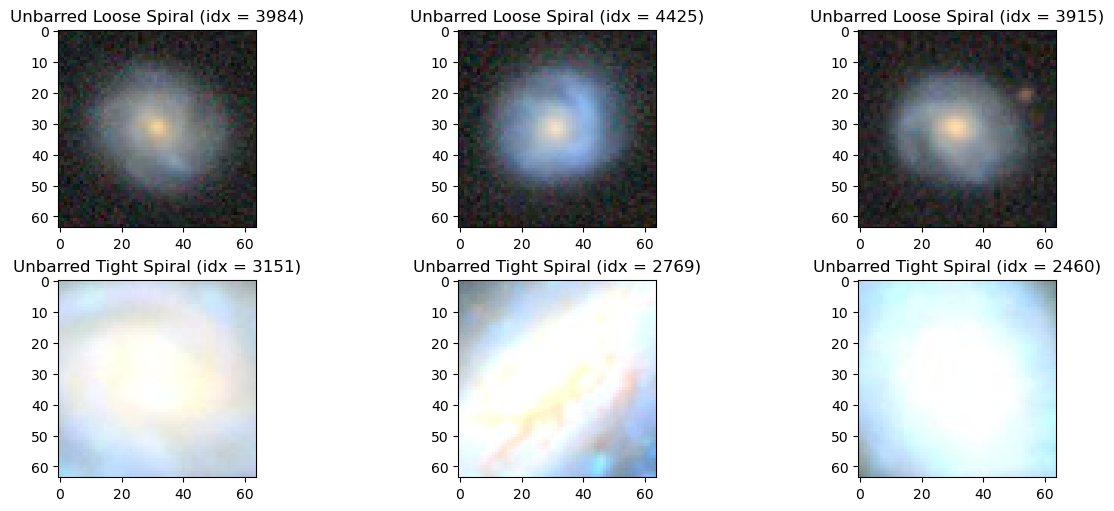

In [21]:
fig, axs = plt.subplots(2, 3, figsize=(12,5), layout='constrained')

for idx, ax in zip(np.append(np.argsort(w_dist)[:3], np.argsort(w_dist)[-3:]), axs.flatten()):

    ax.imshow(images[idx])
    ax.set_title(galaxy10cls_lookup_shift(labels[idx]) + f" (idx = {idx})")

## Autoencoder

In [18]:
import fastprogress


def train(dataloader, optimizer, model, loss_fn, device, master_bar):
    """Run one training epoch.

    Args:
        dataloader (DataLoader): Torch DataLoader object to load data
        optimizer: Torch optimizer object
        model (torch.torch.nn.Module): Torch model to train
        loss_fn: Torch loss function
        device (torch.device): Torch device to use for training
        master_bar (fastprogress.master_bar): Will be iterated over for each
            epoch to draw batches and display training progress

    Returns:
        float: Mean loss of this epoch
    """
    epoch_loss = []

    for x, _ in fastprogress.progress_bar(dataloader, parent=master_bar):
        optimizer.zero_grad()
        model.train()

        # Forward pass
        x = x.to(device)
        x_hat = model(x)

        # Compute loss
        loss = loss_fn(x_hat, x)

        # Backward pass
        loss.backward()
        optimizer.step()

        # For plotting the train loss, save it for each sample
        epoch_loss.append(loss.item())
        master_bar.child.comment = f"Train Loss: {epoch_loss[-1]:.3f}"

    # Return the mean loss and the accuracy of this epoch
    return np.mean(epoch_loss)

def validate(dataloader, model, loss_fn, device, master_bar):
    """Compute loss on validation set.

    Args:
        dataloader (DataLoader): Torch DataLoader object to load data
        model (torch.torch.nn.Module): Torch model to train
        loss_fn: Torch loss function
        device (torch.device): Torch device to use for training
        master_bar (fastprogress.master_bar): Will be iterated over to draw
            batches and show validation progress

    Returns:
        float: Mean loss on validation set
    """
    epoch_loss = []

    model.eval()
    with torch.no_grad():
        for x, _ in fastprogress.progress_bar(dataloader, parent=master_bar):
            # make a prediction on test set
            x = x.to(device)
            x_hat = model(x)

            # Compute loss
            loss = loss_fn(x_hat, x)

            # For plotting the train loss, save it for each sample
            epoch_loss.append(loss.item())
            master_bar.child.comment = f"Valid. Loss: {epoch_loss[-1]:.3f}"

    # Return the mean loss, the accuracy and the confusion matrix
    return np.mean(epoch_loss)

def train_model(model, optimizer, loss_function, device, num_epochs,
                train_dataloader, valid_dataloader):
    """Run model training.

    Args:
        model (torch.torch.nn.Module): Torch model to train
        optimizer: Torch optimizer object
        loss_fn: Torch loss function for training
        device (torch.device): Torch device to use for training
        num_epochs (int): Max. number of epochs to train
        train_dataloader (DataLoader): Torch DataLoader object to load the
            training data
        valid_dataloader (DataLoader): Torch DataLoader object to load the
            test data

    Returns:
        list, list: Return list of train losses, test losses.
    """
    master_bar = fastprogress.master_bar(range(num_epochs))
    epoch_list, train_losses, valid_losses = [], [], []

    master_bar.names = ["Train", "Valid."]

    for epoch in master_bar:
        # Train the model
        epoch_train_loss = train(train_dataloader, optimizer, model, loss_function, device, master_bar)
        # Validate the model
        epoch_valid_loss = validate(valid_dataloader, model, loss_function, device, master_bar)

        # Save loss and acc for plotting
        epoch_list.append(epoch + 1)
        train_losses.append(epoch_train_loss)
        valid_losses.append(epoch_valid_loss)

        graphs = [[epoch_list, train_losses], [epoch_list, valid_losses]]
        x_bounds = [1, num_epochs]

        master_bar.write(
            f"Epoch {epoch + 1}, "
            f"avg. train loss: {epoch_train_loss:.3f}, "
            f"avg. valid. loss: {epoch_valid_loss:.3f}"
        )
        master_bar.update_graph(graphs, x_bounds)


    return train_losses, valid_losses

In [19]:
class Autoencoder(torch.nn.Module):
    def __init__(self, image_size=64, num_channels=1, num_filters=64):
        super(Autoencoder, self).__init__()

        self.image_size   = image_size
        self.num_channels = num_channels
        self.num_filters  = num_filters

        # Encoder
        self.conv_encoder = torch.nn.Sequential(
            torch.nn.Conv2d(self.num_channels, self.num_filters, 3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(self.num_filters, 2 * self.num_filters, 3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(2 * self.num_filters, 4 * self.num_filters, 3, stride=1, padding=1),
            torch.nn.ReLU(),
        )

        # Decoder
        self.conv_decoder = torch.nn.Sequential(
            # The last activation here should be a sigmoid to keep the pixel values clipped in [0, 1)
            torch.nn.ConvTranspose2d(4 * self.num_filters, self.num_channels, 3, stride=1, padding=1),
            torch.nn.Sigmoid(),
        )

    def encode(self, x):
        ''' Encoder: output is (mean, log(variance))'''
        return self.conv_encoder(x)

    def decode(self, z):
        '''Decoder: produces reconstruction from sample of latent z'''
        return self.conv_decoder(z)

    def forward(self, x):
        return self.decode(self.encode(x))

In [20]:
model = Autoencoder(num_channels=3)
model = model.to(device)
model

Autoencoder(
  (conv_encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
  )
  (conv_decoder): Sequential(
    (0): ConvTranspose2d(256, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): Sigmoid()
  )
)

In [21]:
def autoencoder_loss(recon_x, x):
    return torch.nn.functional.mse_loss(recon_x, x, reduction='sum') / x.size(dim=0)

In [22]:
class Features_Dataset(torch.utils.data.Dataset):
    def __init__(self):
        self._load()

    def _load(self):
        self.images = images_torch
        self.labels = labels

    def __getitem__(self, index):
        return self.images[index], self.labels[index]

    def __len__(self):
        return len(self.labels)

In [23]:
train_split = 0.8
valid_split = 0.2

full_dataset = Features_Dataset()

train_dataset, valid_dataset = torch.utils.data.random_split(
        full_dataset, [train_split, valid_split]
)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=64, shuffle=False)

In [24]:
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), learning_rate)

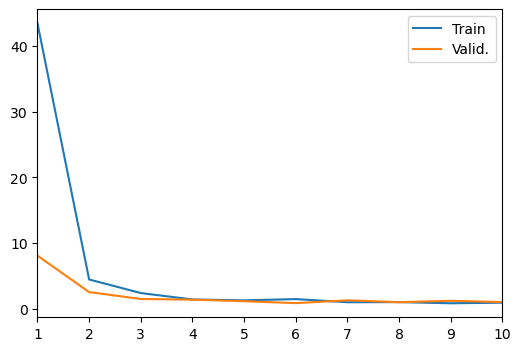

In [32]:
num_epochs = 10

train_model(
    model,
    optimizer,
    autoencoder_loss,
    device,
    num_epochs,
    train_loader,
    valid_loader,
);

In [33]:
torch.save(model, "similarity_model.pkl")

## Evaluate model and get distance in latent space

In [25]:
model = torch.load("similarity_model.pkl", map_location=torch.device('cpu'))

In [26]:
model.eval()
with torch.no_grad():
    pred_best_image = model(images_torch[3984].to("cpu"))
    pred_mw = model(mw_torch.to("cpu"))

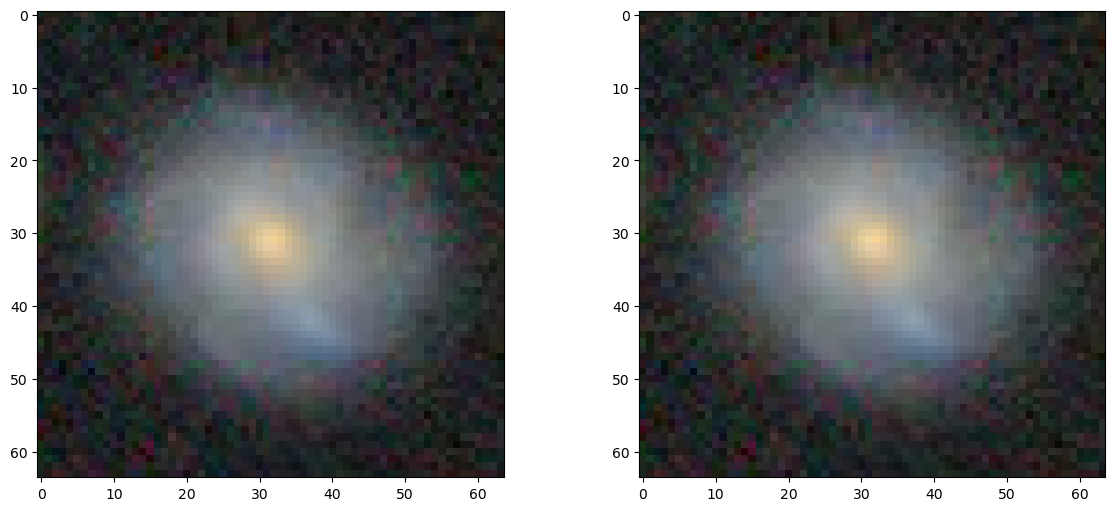

In [27]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(12,5), layout="constrained")
ax0.imshow(pred_best_image.cpu().permute(1,2,0))
ax1.imshow(images_torch[3984].cpu().permute(1,2,0))

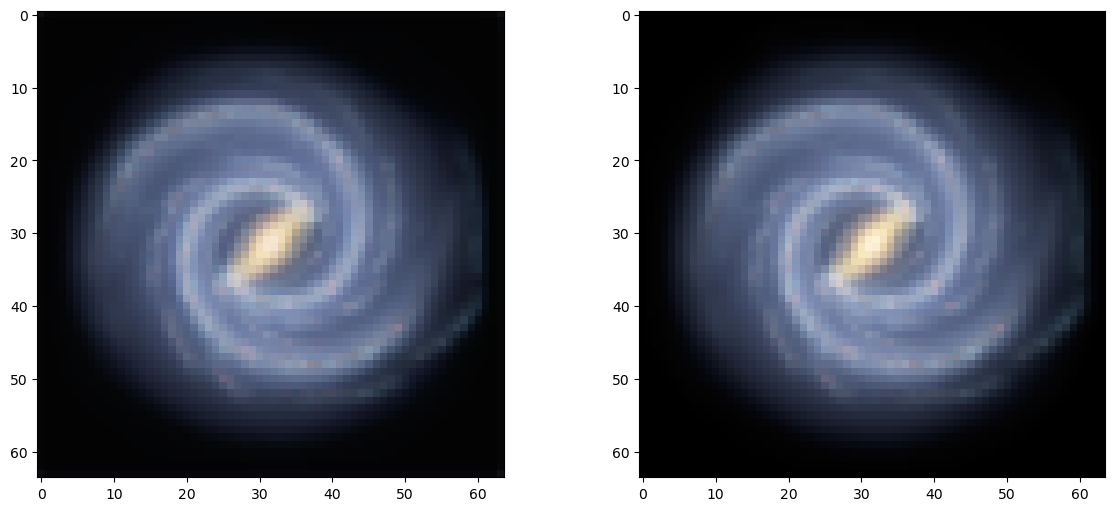

In [28]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(12,5), layout="constrained")
ax0.imshow(pred_mw.cpu().permute(1,2,0))
ax1.imshow(mw_torch.cpu().permute(1,2,0))

In [32]:
torch.set_num_threads(10)

model.to("cpu")
model.eval()
with torch.no_grad():
    encoded_mw = model.encode(mw_torch.to("cpu"))
    dist = torch.sum((model.encode(images_torch.to("cpu")) - encoded_mw[None, ...])**2, dim=(1,2,3))    

In [33]:
encoded_mw.shape

torch.Size([256, 64, 64])

In [34]:
np.argmin(dist)

tensor(3984)